<a href="https://colab.research.google.com/github/roman-bagdasarian/Classifying-Quantum-Phases-of-Matter/blob/main/FLIQ_Challenge_ClassiqDuQIS_2qub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make Sure You Are Ready to Go

$\renewcommand{\ket}[1]{\left| #1 \right\rangle}
\renewcommand{\bra}[1]{\left\langle #1 \right|}
\renewcommand{\braket}[2]{\left\langle #1 | #2 \right\rangle}
\newcommand{\ketbra}[2]{\left| #1 \right\rangle\!\left\langle #2 \right|}$

If you haven't done it yet, try running the following lines of code and use the [registration and installation](https://docs.classiq.io/latest/classiq_101/registration_installations/) page if you are having difficulty setting up your environment.\
Uncomment and run the following command to install or update to the latest version of the Classiq SDK (if not installed yet):

In [1]:
pip install -U classiq

In [2]:
import classiq

Uncomment and run the following command if your machine has not been

authenticated yet, you only need to run it once!

In [3]:
pip install keyrings.alt

In [12]:
#from keyrings.alt.file import PlaintextKeyring

# # Use a basic keyring backend that stores credentials insecurely (for environments like Colab or VS Code)
#keyring.set_keyring(PlaintextKeyring())

# import classiq
classiq.authenticate()

Your user code: QNDW-HQPJ
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=QNDW-HQPJ
Please set a password for your new keyring: ··········
Please confirm the password: ··········


Now you are good to go!

# Rydberg Phase Diagram

Before starting to code, let us reiterating some theory on Rydberg atoms - the subject of this challenge. They interact via the following Hamiltonian:

$$
H = \frac{\Omega}{2} \sum_{i=1}^N X_i
    - \delta \sum_{i=1}^N n_i
    + \sum_{i \lt j} \frac{\Omega R_b^6 }{(a|i-j|)^6} n_i n_j.
$$

You can find the phase diagram for a $51$-atom chain below. It is obtained by fixing $a=1$ and $\Omega=1$ and varying $\delta$ and $R_b$.

<img src="https://github.com/dmitriikhitrin/Classiq-x-DuQIS-FLIQ-Challenge/blob/main/phase_diagram.png?raw=1" alt="Phase Diagram" width="800">


Fig.1: Phase diagram of the 1D Rydberg Hamiltonian, traced out by (left) bipartite entanglement entropy and (right) expectation value of the number of Rydberg excitations. Plots are obtained using tensor-network representation of the ground states of $H$.

In this challenge, we focus on distinguishing between the $Z2$ phase, where the ground state of $H$ has large overlap with the state $\ket{rgr\ldots gr}$, and the $Z3$ phase, where the ground state overlaps strongly with basis states of the form $\ket{\ldots rggrgg\ldots}$.

Evidently, such systems can be efficiently studied using tensor networks. However, this challenge prepares us for a more realistic scenario in which we only have access to measurement outcomes from the ground state of some Hamiltonian, and our goal is to determine which phase of matter the state belongs to.

# Loading and Processing Measurement Data

*   List item
*   List item



Training data for your model contains measurement results in randomized bases performed on a 51-qubit Rydberg atoms chain. We load training data from the .npz file in the next cell.

In [4]:
!wget https://github.com/dmitriikhitrin/Classiq-x-DuQIS-FLIQ-Challenge/raw/main/training_data.npz


--2025-05-18 01:38:38--  https://github.com/dmitriikhitrin/Classiq-x-DuQIS-FLIQ-Challenge/raw/main/training_data.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmitriikhitrin/Classiq-x-DuQIS-FLIQ-Challenge/main/training_data.npz [following]
--2025-05-18 01:38:38--  https://raw.githubusercontent.com/dmitriikhitrin/Classiq-x-DuQIS-FLIQ-Challenge/main/training_data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021888 (998K) [application/octet-stream]
Saving to: ‘training_data.npz’

training_data.npz   100%[===================>] 997.94K  --.-KB/s    in 0.06s   

2025-05-18 01:38:39 (16.8

In [5]:
import numpy as np
# You might need to make additional imports depending on your implementation

In [6]:
loaded = np.load("training_data.npz", allow_pickle=True)


unprocessed_features = loaded["features"].tolist()
unprocessed_labels = loaded["labels"].tolist()

print(f'There are {len(unprocessed_features)} data points')
print(f'There were T = {len(unprocessed_features[0])} measurements performed for each data point')
print(f'The measurements were performed on {len(unprocessed_features[0][0])} qubits')
print(f'Example: 2nd experiment result of 8th data point -> {unprocessed_features[7][1]}')
print(f'Example: label for the 8th data point -> {unprocessed_labels[7]}')

There are 20 data points
There were T = 500 measurements performed for each data point
The measurements were performed on 51 qubits
Example: 2nd experiment result of 8th data point -> ['r', '-', 'i', 'i', 'r', '+', 'r', 'g', '+', '-i', 'r', '-', '-', 'g', '-i', '-', 'r', 'g', 'i', 'i', 'i', '-', 'r', '-i', 'r', 'i', 'r', '+', 'i', 'g', '-', '-i', '-', 'g', '-i', 'i', 'r', '-', '-', '-', 'i', 'i', '-i', 'g', '-i', 'g', 'r', '-', 'r', '+', '-']
Example: label for the 8th data point -> Z2


In the above,
- $\ket{g}$ is the atomic ground state, which is a $+1$-eigenstate of Pauli $Z$
- $\ket{r}$ is the highly excited Rydberg state, which is a $-1$-eigenstate of Pauli $Z$
- $\ket{+} = \frac{1}{\sqrt2}(\ket{g} + \ket{r})$, a $+1$-eigenstate of Pauli $X$
- $\ket{-} = \frac{1}{\sqrt2}(\ket{g} - \ket{r})$, a $-1$-eigenstate of Pauli $X$
- $\ket{+i} = \frac{1}{\sqrt2}(\ket{g} +i\ket{r})$, a $+1$-eigenstate of Pauli $Y$
- $\ket{-i} = \frac{1}{\sqrt2}(\ket{g} -i \ket{r})$, a $-1$-eigenstate of Pauli $Y$.

It is up to you how to convert the features into classical shadows and labels into numbers and then both into training data for your model. For example, you could assign $-1$ to $Z2$ and $+1$ to $Z3$.

**Note:** If you decide to define any helper classes/functions in a separate Python file, please submit it alongside your solution notebook, so we can run and grade it properly

In [31]:
# ─── Cell 1: Load → Classical Shadows → PCA (8 features) ───
import numpy as np
from sklearn.decomposition import PCA

# 1) Load raw data
data       = np.load("training_data.npz", allow_pickle=True)
raw_feats  = data["features"].tolist()   # 20 × 500 × 51
raw_labels = data["labels"].tolist()     # 20 labels

N, T, Q0 = len(raw_feats), len(raw_feats[0]), len(raw_feats[0][0])

# 2) Build classical shadows σ = 3|v⟩⟨v| – I
I2 = np.eye(2, dtype=complex)
basis = {
  'g': np.array([1,0],complex),
  'r': np.array([0,1],complex),
  '+': (1/np.sqrt(2))*np.array([1,1],complex),
  '-': (1/np.sqrt(2))*np.array([1,-1],complex),
  '+i':(1/np.sqrt(2))*np.array([1,1j],complex),
  '-i':(1/np.sqrt(2))*np.array([1,-1j],complex),
}
σ_op = {k:3*np.outer(v,v.conj()) - I2 for k,v in basis.items()}
norm = lambda s: '+i' if s.strip().replace('−','-')=='i' else s.strip().replace('−','-')

# 3) Accumulate shadows
S = np.zeros((N, Q0, 2, 2), complex)
for i, shots in enumerate(raw_feats):
    acc = np.zeros((Q0,2,2), complex)
    for shot in shots:
        for q, o in enumerate(shot):
            acc[q] += σ_op[norm(o)]
    S[i] = acc / T

# 4) Bloch angles θx, θz
σx = np.array([[0,1],[1,0]], complex)
σz = np.array([[1,0],[0,-1]], complex)
ρ  = (S + I2)/3
ex = np.real(np.trace(ρ @ σx, axis1=2, axis2=3))
ez = np.real(np.trace(ρ @ σz, axis1=2, axis2=3))
θx = (np.clip(ex,-1,1)+1)*(np.pi/2)
θz = (np.clip(ez,-1,1)+1)*(np.pi/2)

# 5) Flatten to complex vector and split real/imag
Xc    = (θx + 1j*θz).reshape(N, -1)    # shape (20,204)
Xreal = np.hstack([Xc.real, Xc.imag])  # (20,408)

# 6) PCA to 6 real features
Xp    = PCA(n_components=4, random_state=0).fit_transform(Xreal)
mn, mx = Xp.min(0), Xp.max(0)
Xp_norm = (Xp - mn)/np.where(mx-mn==0,1,(mx-mn))*np.pi  # normalize to [0,π]

X_sub    = Xp_norm                       # (20, 4)
y        = np.array([ -1 if lbl=='Z2' else +1 for lbl in raw_labels ])

print("X_sub:", X_sub.shape, " y:", y.shape)


# ── Split into training and validation sets ──
from sklearn.model_selection import train_test_split

# 70% train, 30% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_sub, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Train size: {len(X_train)},  Val size: {len(X_val)}")


X_sub: (20, 4)  y: (20,)
Train size: 14,  Val size: 6


# Defining a Quantum Model

In this section, you will create a QML model for classifying the quantum phases. This will include 3 stages:
- First, you will need to decide on the data encoding scheme, i.e. loading numerical features you obtained above into the quantum circuit.
- Then, you will need to come up with an ansatz - a parametrized quantum circuit, which will be optimized to perform classification.
- Finally, to readout classical information from the quantum model, you will need to perform some sort of measurement on the resultant quantum state. Perhaps, you could extract an expectation value of some Pauli-string $P \in \{I, X, Y, Z\}^{\otimes N}$, so that $\langle P \rangle < b$ is interpreted as $Z2$ and  $\langle P \rangle > b$ is interpreted as $Z3$ for some decision boundary $b$.

There are several approaches to QML in Classiq, linked below.

You may find the following guides useful:
- QML with Classiq: http://docs.classiq.io/latest/user-guide/read/qml_with_classiq_guide/
- Variational Model Example: https://github.com/Classiq/classiq-library/blob/main/algorithms/qaoa/maxcut/qaoa_max_cut.ipynb
- Hybrid QNN: https://docs.classiq.io/latest/explore/algorithms/qml/hybrid_qnn/hybrid_qnn_for_subset_majority/

Although the 2nd guide describes a hybrid model, **you may not implement a hybrid model**, the guide should only be used as a reference as to how to implement QML.

**Warning**: Training using the Classiq PyTorch integration may take a prohibitive amount of time. Consider this when choosing an approach.

In [14]:
from classiq import *
from classiq.execution import *
import numpy as np
from classiq.synthesis import synthesize, show

In [15]:
from classiq import (
    qfunc, CArray, CReal, QArray, QBit, Output,
    allocate, RY, RZ, RX, CZ,
    create_model, Constraints
)
from classiq.execution import (
    ExecutionPreferences, ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames
)
from classiq.synthesis import synthesize, show

# ─── Hyperparameters ─────────────────────────────────────────
feature_length = 4   # matches PCA output
num_qubits     = 2
num_weights    = 2   # shared RX & RZ

# ─── Encoding: 4 features → 2 qubits (2 angles each) ─────────
@qfunc
def encoding(f: CArray[CReal, feature_length], wires: QArray) -> None:
    for q in range(num_qubits):
        i0 = 2 * q
        RY(theta=f[i0],     target=wires[q])
        RZ(theta=f[i0 + 1], target=wires[q])

# ─── Ansatz: same 2-param structure ───────────────────────────
@qfunc
def ansatz(weights: CArray[CReal, num_weights], wires: QArray) -> None:
    # 1) shared RX
    for i in range(num_qubits):
        RX(theta=weights[0], target=wires[i])
    # 2) ring of CZ
    for i in range(num_qubits):
        CZ(ctrl=wires[i], target=wires[(i+1) % num_qubits])
    # 3) shared RZ
    for i in range(num_qubits):
        RZ(theta=weights[1], target=wires[i])


@qfunc
def main(
    feature: CArray[CReal, feature_length],
    weights: CArray[CReal, num_weights],
    result:  Output[QArray[QBit]],
) -> None:
    allocate(num_qubits, result)
    encoding(feature, wires=result)
    # two back-to-back ansatz layers
    ansatz(weights,   wires=result)
    ansatz(weights,   wires=result)


### Synthesis

Before training, you must synthesize your model into a quantum program. Placeholders for your parameters will be automatically generated.

You may find the following documentation useful: https://docs.classiq.io/latest/sdk-reference/synthesis/

In [16]:
# Synthesis
NUM_SHOTS = 1000
BACKENDS  = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR
)

QMOD  = create_model(
    main,
    execution_preferences=ExecutionPreferences(
        num_shots=NUM_SHOTS,
        backend_preferences=BACKENDS
    ),
    constraints=Constraints(optimization_parameter="no_opt")
)
QPROG = synthesize(QMOD)
show(QPROG)

Quantum program link: https://platform.classiq.io/circuit/2xFShmTuyITvzgqj8awsTT98VmG?login=True&version=0.79.1


# Training the Model

Here, you will optimize the weights in ansatz, so that the model can distiguish between the phases.

You can find the following Classiq tutorial and documentation useful:
- Execution: https://docs.classiq.io/latest/sdk-reference/execution/
- Execution Session: https://docs.classiq.io/latest/user-guide/execution/ExecutionSession/
- Executing With Parameters: https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-entry-point/

It is highly recommended to use an ExecutionSession if you are executing the same circuit with different parameters many times. It is not needed to train parameters using the Classiq PyTorch integration.

If you are not using the PyTorch integration, you will need an objective (also known as a 'loss', or 'cost') function. Depending on your implementation, you will need to either minimize or maximize it in training.

In [32]:
# ─── Cell 3 (updated): 64→256-shot SPSA with train/val and full logger ───

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from classiq.execution import ExecutionSession, ExecutionPreferences
from classiq._internals.client import ClassiqAPIError

# 1) Sessions
def make_session(shots: int, fast: bool) -> ExecutionSession:
    prefs = ExecutionPreferences(
        num_shots=shots,
        backend_preferences=BACKENDS,
        fast=fast
    )
    return ExecutionSession(quantum_program=QPROG,
                            execution_preferences=prefs)

sess64  = make_session(64,  fast=True)
sess256 = make_session(256, fast=False)
sess_val = make_session(256, fast=False)   # for validation loss

# 2) Helpers: bind & avg_z
def bind(tag, arr):
    return {f"{tag}_param_{i}": float(v) for i, v in enumerate(arr)}

def avg_z(counts):
    tot = sum(counts.values())
    return sum(
        c * sum(+1 if b=='0' else -1 for b in bits)
        for bits, c in counts.items()
    ) / (tot * num_qubits)

# 3) Batch‐forward and safe wrapper
def batch_forward(sess, thetas, Xb):
    plist = [
        {**bind("weights", w), **bind("feature", x)}
        for w, x in zip(thetas, Xb)
    ]
    results = sess.batch_sample(parameters=plist)
    cnts = [
        r.counts if isinstance(r.counts, dict) else r.counts[0]
        for r in results
    ]
    return np.array([avg_z(c) for c in cnts])

def safe_batch_forward(sess, thetas, Xb,
                       max_retries=3, delay=0.2):
    for attempt in range(1, max_retries+1):
        try:
            out = batch_forward(sess, thetas, Xb)
            time.sleep(delay)
            return out
        except ClassiqAPIError as e:
            print(f"⚠️ API error (attempt {attempt}): {e}")
            time.sleep(delay * attempt)
    raise RuntimeError("batch_forward failed after retries")

# 4) Hinge loss & decision‐value functions
def hinge(sess, w, X, y):
    N = X.shape[0]
    logits = safe_batch_forward(sess, np.tile(w, (N,1)), X)
    return np.mean(np.maximum(0, 1 - y * logits))

def compute_logits(sess, w, X):
    N = X.shape[0]
    return safe_batch_forward(sess, np.tile(w, (N,1)), X)

# ── Logs & best‐tracker ──
train_loss_log = []
val_loss_log   = []
best_acc       = -1.0
best_theta     = None

# 5) SPSA hyperparameters & init
alpha, c0, gamma = 0.80, 0.10, 0.05
MAX_IT = 80
theta  = 0.01 * np.random.randn(num_weights)

# 6) SPSA loop with full logger
for k in range(MAX_IT):
    sess = sess64 if k < 50 else sess256
    ck   = c0 / (k + 1)**gamma
    delta = np.random.choice([+1, -1], num_weights)

    # gradient estimate on training set
    lp = hinge(sess, theta + ck*delta, X_train, y_train)
    lm = hinge(sess, theta - ck*delta, X_train, y_train)
    grad = (lp - lm) / (2 * ck * delta)
    theta -= alpha * grad

    # checkpoint every 20 its + last
    if k % 20 == 0 or k == MAX_IT - 1:
        # train metrics
        L_train = hinge(sess, theta, X_train, y_train)
        logits_tr = compute_logits(sess, theta, X_train)
        preds_tr  = np.sign(logits_tr)
        y_tr_bin  = (y_train == +1).astype(int)
        p_tr_bin  = (preds_tr  == +1).astype(int)
        acc_train = np.mean(preds_tr == y_train)
        prec = precision_score(y_tr_bin, p_tr_bin, zero_division=0)
        rec  = recall_score(   y_tr_bin, p_tr_bin, zero_division=0)
        f1s  = f1_score(       y_tr_bin, p_tr_bin, zero_division=0)

        # validation loss
        L_val = hinge(sess_val, theta, X_val, y_val)

        epoch = len(train_loss_log) + 1
        print(
            f"Epoch {epoch:02d} | "
            f"train loss={L_train:.4f} | "
            f"val loss={L_val:.4f} | "
            f"train acc={acc_train*100:5.2f}% | "
            f"precision={prec*100:5.2f}% | "
            f"recall={rec*100:5.2f}% | "
            f"F1={f1s*100:5.2f}%"
        )

        # log & track best
        train_loss_log.append(L_train)
        val_loss_log.append(L_val)
        if acc_train > best_acc:
            best_acc   = acc_train
            best_theta = theta.copy()

# 7) Cleanup
sess64.close()
sess256.close()
sess_val.close()

print(f"\nBest train accuracy seen: {best_acc*100:.2f}%")


Epoch 01 | train loss=1.5561 | val loss=1.3288 | train acc= 7.14% | precision=12.50% | recall=14.29% | F1=13.33%
Epoch 02 | train loss=0.7121 | val loss=0.6608 | train acc=85.71% | precision=100.00% | recall=71.43% | F1=83.33%
Epoch 03 | train loss=0.7051 | val loss=0.9434 | train acc=78.57% | precision=83.33% | recall=71.43% | F1=76.92%
Epoch 04 | train loss=0.6914 | val loss=0.6927 | train acc=64.29% | precision=100.00% | recall=28.57% | F1=44.44%
Epoch 05 | train loss=0.5700 | val loss=0.6126 | train acc=85.71% | precision=100.00% | recall=71.43% | F1=83.33%

Best train accuracy seen: 85.71%


Training that takes too long may make it impossible to grade your submission.

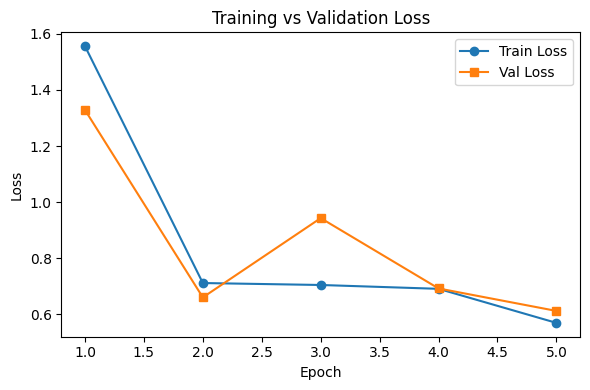

In [33]:
import matplotlib.pyplot as plt

# build epoch indices
epochs = list(range(1, len(train_loss_log) + 1))

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss_log, '-o', label='Train Loss')
plt.plot(epochs, val_loss_log,   '-s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Testing the Model

Good job! Now it's time to see whether the model you designed can successfully perform the classification. For this, compare the predictions of your model to the actual labels.

If the model does not perform well, try modifying the encoding and/or the ansatz (by using different number of parameters/qubits/ansatz layers/...)

## Grading

You will be evaluated on the accuracy, depth, width of your model and the number of parameters in your model.

The following function will return the width and depth of your model as they will be used in grading. Use it to self-evaluate your model.

In [35]:
from classiq import QuantumProgram

def get_metrics(qprog):
    """
    Extract circuit metrics from a quantum program.

    Parameters:
        qprog: The quantum program object.

    Returns:
        dict: A dictionary containing the circuit metrics:
              - "depth": Circuit depth
              - "width": Circuit width
    """
    circuit = QuantumProgram.from_qprog(qprog)

    metrics = {
        "depth": circuit.transpiled_circuit.depth,
        "width": circuit.data.width,
    }

    return metrics

In [38]:
print(get_metrics(QPROG))

{'depth': 10, 'width': 2}


In [46]:
# ─── Final f‐score calculation ───

# 1) Spin up a fresh eval session
sess_eval = make_session(256, fast=False)

# 2) Compute logits & predictions on the validation set
N_val = X_val.shape[0]
logits = safe_batch_forward(
    sess_eval,
    np.tile(best_theta, (N_val, 1)),
    X_val
)
preds = np.where(logits > 0, +1, -1)

# 3) Final accuracy
A_final = np.mean(preds == y_val)
print(f"Validation accuracy: {A_final*100:5.2f}%")

# 4) Parameter count
P = len(best_theta)

# 5) Circuit metrics
metrics = get_metrics(QPROG)
D = metrics["depth"]
W = metrics["width"]

# 6) Compute and print f‐score
f_score = A_final - 0.1*P - 0.0002*D - 0.1*W
print(f"Final f-score: {f_score:.4f}")

# 7) Cleanup
sess_eval.close()


Validation accuracy: 83.33%
Final f-score: 0.4313


# Submission

You will submit this notebook, your trained parameters, and your quantum model.

In [21]:
# Do not change this cell

import os

def save_qprog(qprog, team_name: str, folder="."):
    assert isinstance(team_name, str)
    file_name = f"{team_name.replace(' ','_')}.qprog"
    with open(os.path.join(folder, file_name), 'w') as f:
        f.write(qprog.model_dump_json(indent=4))

def save_params(params, team_name: str, folder="."):
    assert isinstance(team_name, str)
    file_name = f"{team_name.replace(' ','_')}.npz"
    with open(os.path.join(folder, file_name), 'wb') as f:
        np.savez(f, params=params)

In [ ]:
# Change to your team name!!
TEAM_NAME = "Merqury"

# Insert your trained parameters here!
TRAINED_PARAMS = theta

save_qprog(QPROG, team_name=TEAM_NAME)
save_params(params=TRAINED_PARAMS, team_name=TEAM_NAME)